In [1]:
from numpy import prod
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import cv2
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 9]

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import LabelBinarizer
import collections


Bad key "text.kerning_factor" on line 4 in
/home/vadim/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
CURRENT_DIR = '/home/vadim/testovoe/dev/'

In [3]:
test_df = pd.read_csv(CURRENT_DIR+"Data/text.txt", sep="\s+", header=None, names=["name", "category"])
train_df = pd.read_csv(CURRENT_DIR+"Data/train_half.txt", sep="\s+", header=None, names=["name", "category"])

In [4]:
print(train_df.shape)
print(test_df.shape)
train_df.head()

(2709, 2)
(900, 2)


name  category
0  Data/train/human/125655.JPEG         0
1  Data/train/human/115966.JPEG         0
2  Data/train/human/150910.JPEG         0
3  Data/train/human/154958.JPEG         0
4  Data/train/human/150133.JPEG         0

1    903
2    903
0    903
Name: category, dtype: int64

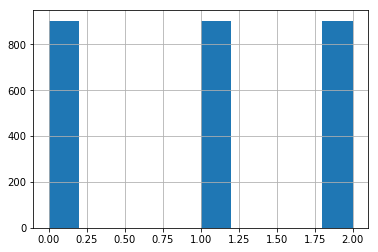

In [5]:
train_df['category'].hist()
train_df['category'].value_counts()

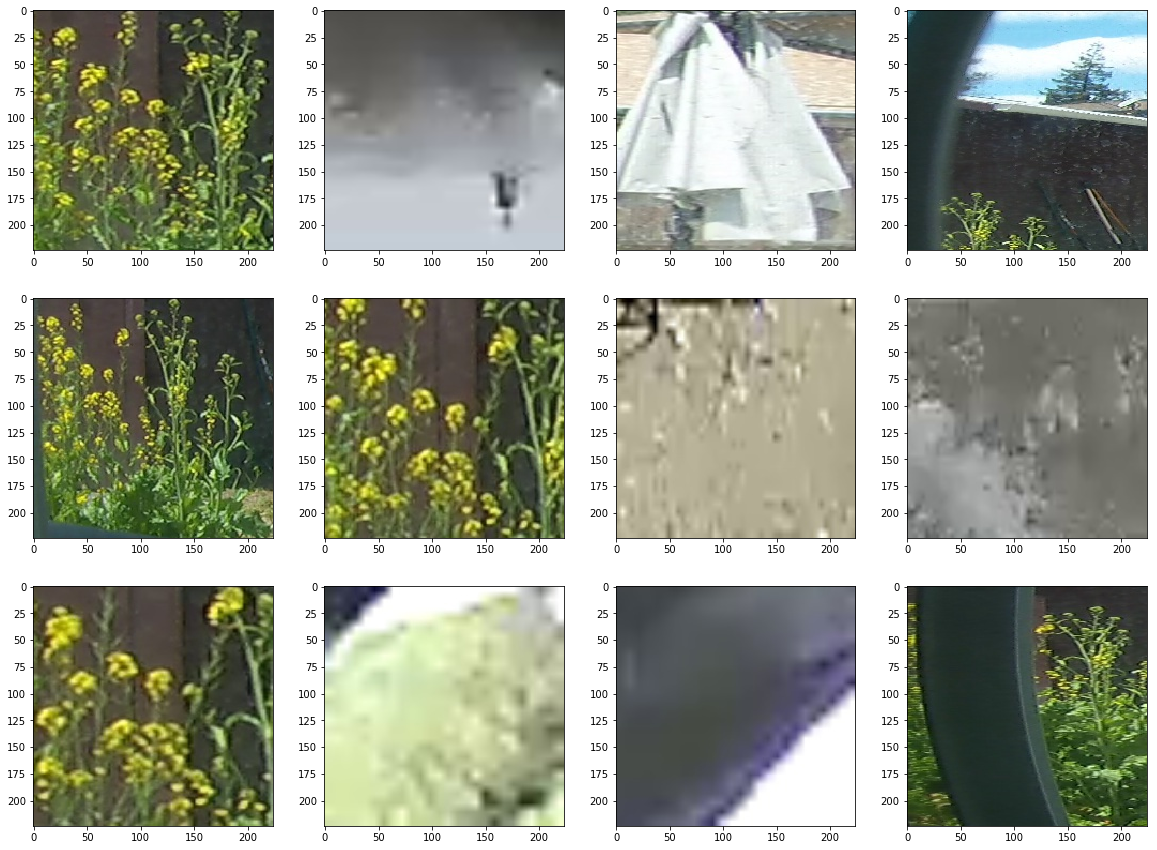

In [6]:
fig = plt.figure(figsize = (20, 15))
for idx, img_name in enumerate(train_df[train_df['category'] == 2]['name'][:12]):
    y = fig.add_subplot(3, 4, idx+1)
    img = cv2.imread(os.path.join(CURRENT_DIR,img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    y.imshow(img)

plt.show()

In [7]:
print(train_df[train_df['category'] == 2])

                              name  category
1806  Data/train/noise/125655.JPEG         2
1807  Data/train/noise/115966.JPEG         2
1808  Data/train/noise/150910.JPEG         2
1809  Data/train/noise/154958.JPEG         2
1810  Data/train/noise/150133.JPEG         2
...                            ...       ...
2704  Data/train/noise/139325.JPEG         2
2705  Data/train/noise/133108.JPEG         2
2706  Data/train/noise/121002.JPEG         2
2707  Data/train/noise/155455.JPEG         2
2708  Data/train/noise/120957.JPEG         2

[903 rows x 2 columns]


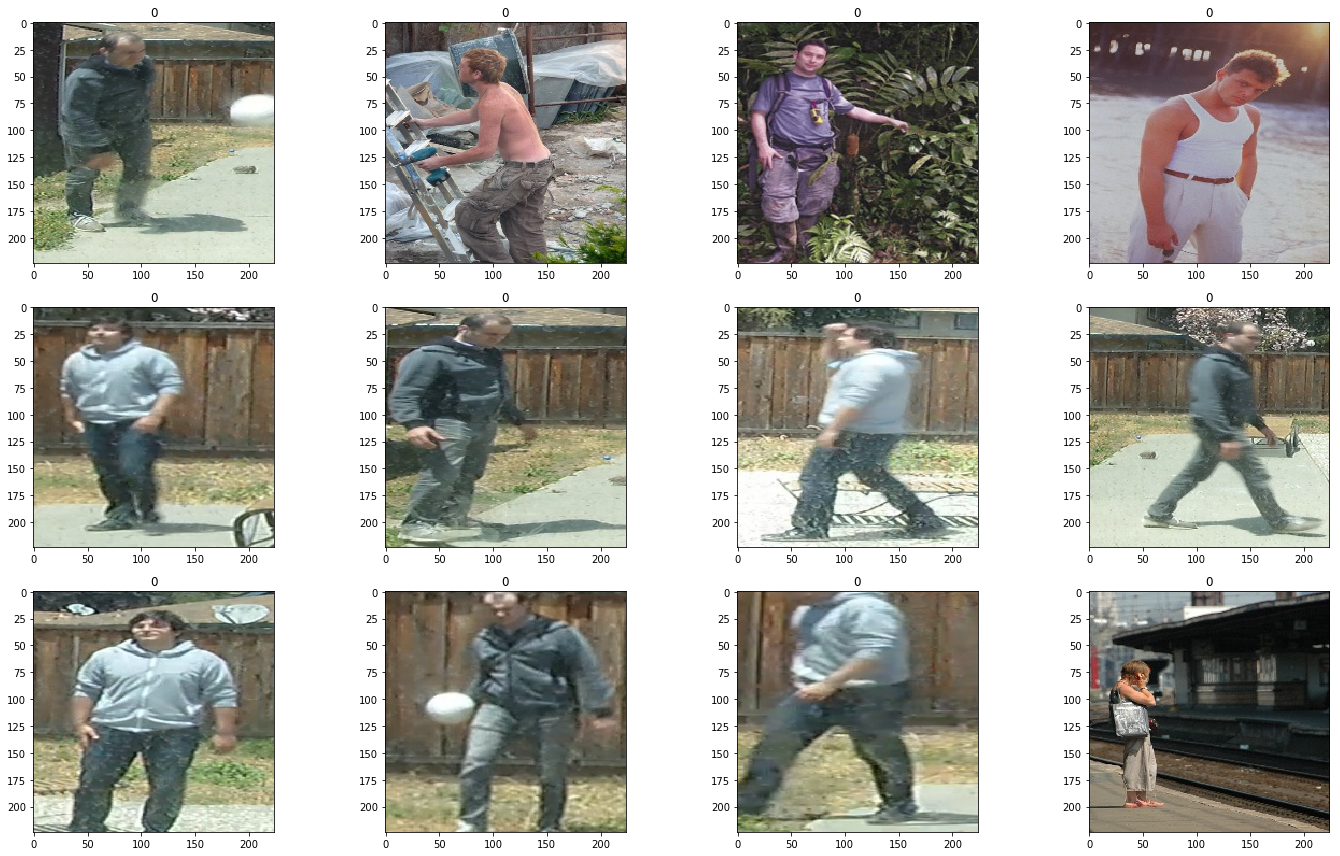

In [8]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'name']
        image_id = df.loc[i,'category']
        img = cv2.imread(f'/home/vadim/testovoe/dev/{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

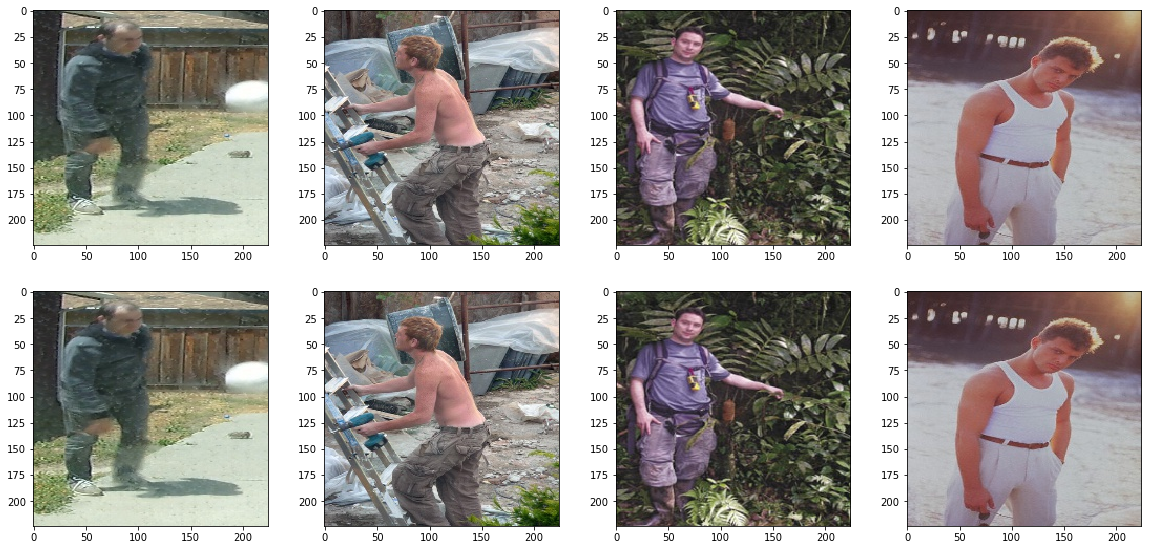

In [9]:
topN=5
top_human = train_df['category'].value_counts().index[1:1+topN]
fig = plt.figure(figsize = (20, 5*topN))

for widx, human in enumerate(top_human):
    for idx, img_name in enumerate(train_df[train_df['category'] == 0]['name'][:4]):
        axes = widx*4 + idx+1
        y = fig.add_subplot(topN, 4, axes)
        img = cv2.imread(os.path.join(CURRENT_DIR,img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        y.imshow(img)

plt.show()

In [10]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [11]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['name'])):
    x_train[i, :, :, :] = preprocess_image(
         f'/home/vadim/testovoe/dev/{image_id}'
    )

100%|██████████| 2709/2709 [00:02<00:00, 1046.14it/s]


In [12]:
N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['name'])):
    x_test[i, :, :, :] = preprocess_image(
         f'/home/vadim/testovoe/dev/{image_id}'
    )

100%|██████████| 900/900 [00:00<00:00, 1040.25it/s]


In [13]:
y_test = pd.get_dummies(test_df['category']).values

In [14]:
import imagehash

def getImageMetaData(file_path):
    with Image.open(file_path) as img:
        img_hash = imagehash.phash(img)
        return img.size, img.mode, img_hash

def get_img_duplicates_info(df, dataset):
    
    m = df.name.apply(lambda x: getImageMetaData(os.path.join(CURRENT_DIR, x)))
    df["Hash"] = [str(i[2]) for i in m]
    df["Shape"] = [i[0] for i in m]
    df["Mode"] = [str(i[1]) for i in m]
    df["Length"] = df["Shape"].apply(lambda x: x[0]*x[1])
    df["Ratio"] = df["Shape"].apply(lambda x: x[0]/x[1])
    df["New_human"] = df.category == 0
    
    
    img_counts = df.category.value_counts().to_dict()
    df["category_Count"] = df.category.apply(lambda x: img_counts[x])
    return df

In [15]:
train_dups = get_img_duplicates_info(train_df, "train")

In [16]:
train_dups

name  category              Hash       Shape  \
0     Data/train/human/125655.JPEG         0  a158c69784afbf60  (224, 224)   
1     Data/train/human/115966.JPEG         0  b68826af0f4b4f58  (224, 224)   
2     Data/train/human/150910.JPEG         0  c0731d711c7bdc2c  (224, 224)   
3     Data/train/human/154958.JPEG         0  bc0326acb8f2666b  (224, 224)   
4     Data/train/human/150133.JPEG         0  f14db3380e318b73  (224, 224)   
...                            ...       ...               ...         ...   
2704  Data/train/noise/139325.JPEG         2  97ffaba919516880  (224, 224)   
2705  Data/train/noise/133108.JPEG         2  c36a2519dfdf4c10  (224, 224)   
2706  Data/train/noise/121002.JPEG         2  bef7a3298d45a182  (224, 224)   
2707  Data/train/noise/155455.JPEG         2  d6d2aaa5d5aa4a54  (224, 224)   
2708  Data/train/noise/120957.JPEG         2  d6570d0ad4596cf1  (224, 224)   

     Mode  Length  Ratio  New_human  category_Count  
0     RGB   50176    1.0       True             903  
1     RGB   50176    1.0       True             903  
2     RGB   50176    1.0       True             903  
3     RGB   50176    1.0       True             903  
4     RGB   50176    1.0       True             903  
...   ...     ...    ...        ...             ...  
2704  RGB   50176    1.0      False             903  
2705  RGB   50176    1.0      False             903  
2706  RGB   50176    1.0      False             903  
2707  RGB   50176    1.0      False             903  
2708  RGB   50176    1.0      False             903  

[2709 rows x 9 columns]

In [17]:
t = train_dups.Hash.value_counts()
t = t.loc[t>1]

In [18]:
"Duplicate hashes: {}".format(len(t))

'Duplicate hashes: 21'

In [19]:
t

886b63879fe1616c    5
96db9399939892f0    4
d5a5299c8e979692    3
c87ce3e343d7c0c8    3
bd628cbb66408f71    2
9d56d6bcd6461c18    2
a0c009e7be84f99f    2
878f9c9c9c947293    2
b061dbf2e1aba0a5    2
b86143718ff29cb8    2
883b63879fe1616c    2
e8d0e215fa18dd1e    2
ea4a277552ac2f70    2
dac24fd88a9e989a    2
caca6ebe15caa292    2
a1466fdc50c1dadc    2
bc0326acb8f2666b    2
e1f1215cd097fc43    2
8d8f3932364cd333    2
d7ab0f060bbc7254    2
9446cce5f517a631    2
Name: Hash, dtype: int64

In [20]:
t.index[0]

'886b63879fe1616c'

In [21]:
train_dups[train_dups['Hash'] == t.index[0]].head()

name  category              Hash       Shape  \
1950  Data/train/noise/144373.JPEG         2  886b63879fe1616c  (224, 224)   
2006  Data/train/noise/131184.JPEG         2  886b63879fe1616c  (224, 224)   
2163  Data/train/noise/156903.JPEG         2  886b63879fe1616c  (224, 224)   
2509  Data/train/noise/143001.JPEG         2  886b63879fe1616c  (224, 224)   
2583  Data/train/noise/158272.JPEG         2  886b63879fe1616c  (224, 224)   

     Mode  Length  Ratio  New_human  category_Count  
1950  RGB   50176    1.0      False             903  
2006  RGB   50176    1.0      False             903  
2163  RGB   50176    1.0      False             903  
2509  RGB   50176    1.0      False             903  
2583  RGB   50176    1.0      False             903

In [22]:
train_dups[train_dups['Hash'] == t.index[20]].head()

name  category              Hash       Shape  \
2110  Data/train/noise/131903.JPEG         2  9446cce5f517a631  (224, 224)   
2155  Data/train/noise/122129.JPEG         2  9446cce5f517a631  (224, 224)   

     Mode  Length  Ratio  New_human  category_Count  
2110  RGB   50176    1.0      False             903  
2155  RGB   50176    1.0      False             903

In [23]:
print(img_name)

Data/train/human/154958.JPEG


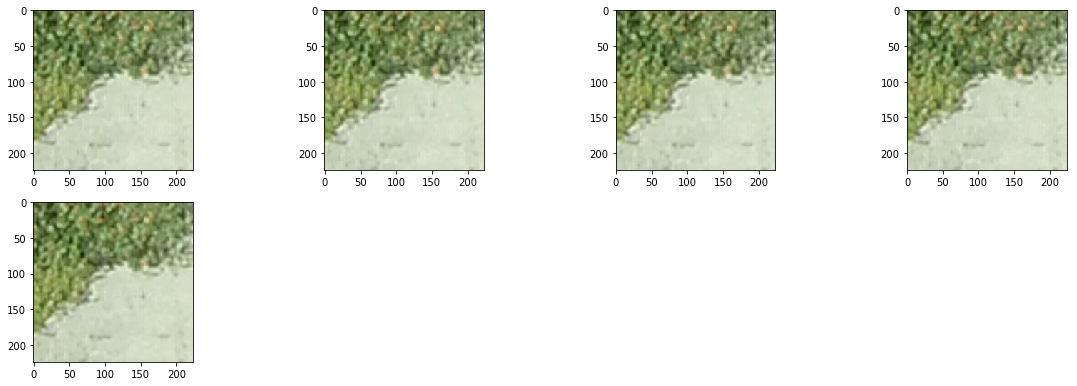

In [24]:
fig = plt.figure(figsize = (20, 10))
for idx, img_name in enumerate(train_dups[train_dups['Hash'] == t.index[0]]['name'][:5]):
    y = fig.add_subplot(3, 4, idx+1)
    img = cv2.imread(os.path.join(CURRENT_DIR,img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    y.imshow(img)

plt.show()

In [25]:
test_dups = get_img_duplicates_info(test_df, "test")

In [26]:
test_d = test_dups.Hash.value_counts()
test_d = test_d.loc[test_d>1]
"Duplicate hashes in test: {}".format(len(test_d))

'Duplicate hashes in test: 6'

In [27]:
common_hashes = test_dups.merge(train_dups, how="inner", on="Hash", suffixes=("_test","_train"))
common_hashes.head()

name_test  category_test              Hash  Shape_test  \
0  Data/test/human/109784.JPEG              0  b106cfb14e4c966b  (224, 224)   
1  Data/test/noise/113254.JPEG              2  a5252d9ad2d2d2da  (224, 224)   
2  Data/test/noise/106256.JPEG              2  87f0de4ce8f99e00  (224, 224)   
3  Data/test/noise/112702.JPEG              2  b59195d1686aaabc  (224, 224)   
4  Data/test/noise/107373.JPEG              2  c5d8dc17331bf40c  (224, 224)   

  Mode_test  Length_test  Ratio_test  New_human_test  category_Count_test  \
0       RGB        50176         1.0            True                  300   
1       RGB        50176         1.0           False                  300   
2       RGB        50176         1.0           False                  300   
3       RGB        50176         1.0           False                  300   
4       RGB        50176         1.0           False                  300   

                     name_train  category_train Shape_train Mode_train  \
0  Data/train/human/126697.JPEG               0  (224, 224)        RGB   
1  Data/train/noise/121547.JPEG               2  (224, 224)        RGB   
2  Data/train/noise/133982.JPEG               2  (224, 224)        RGB   
3  Data/train/noise/158239.JPEG               2  (224, 224)        RGB   
4  Data/train/noise/139527.JPEG               2  (224, 224)        RGB   

   Length_train  Ratio_train  New_human_train  category_Count_train  
0         50176          1.0             True                   903  
1         50176          1.0            False                   903  
2         50176          1.0            False                   903  
3         50176          1.0            False                   903  
4         50176          1.0            False                   903

In [28]:
common_hashes

name_test  category_test              Hash  Shape_test  \
0   Data/test/human/109784.JPEG              0  b106cfb14e4c966b  (224, 224)   
1   Data/test/noise/113254.JPEG              2  a5252d9ad2d2d2da  (224, 224)   
2   Data/test/noise/106256.JPEG              2  87f0de4ce8f99e00  (224, 224)   
3   Data/test/noise/112702.JPEG              2  b59195d1686aaabc  (224, 224)   
4   Data/test/noise/107373.JPEG              2  c5d8dc17331bf40c  (224, 224)   
5   Data/test/noise/106183.JPEG              2  c5d8dc17331bf40c  (224, 224)   
6   Data/test/noise/100132.JPEG              2  d4a748d615ee8956  (224, 224)   
7   Data/test/noise/109928.JPEG              2  d4a748d615ee8956  (224, 224)   
8   Data/test/noise/100426.JPEG              2  b3446fbb897f5800  (224, 224)   
9   Data/test/noise/111010.JPEG              2  b3446fbb897f5800  (224, 224)   
10  Data/test/noise/109961.JPEG              2  96db9399939892f0  (224, 224)   
11  Data/test/noise/109961.JPEG              2  96db9399939892f0  (224, 224)   
12  Data/test/noise/109961.JPEG              2  96db9399939892f0  (224, 224)   
13  Data/test/noise/109961.JPEG              2  96db9399939892f0  (224, 224)   
14  Data/test/noise/107644.JPEG              2  96db9399939892f0  (224, 224)   
15  Data/test/noise/107644.JPEG              2  96db9399939892f0  (224, 224)   
16  Data/test/noise/107644.JPEG              2  96db9399939892f0  (224, 224)   
17  Data/test/noise/107644.JPEG              2  96db9399939892f0  (224, 224)   
18  Data/test/noise/108349.JPEG              2  877078636e5c5cc9  (224, 224)   
19  Data/test/noise/105136.JPEG              2  9be5c8c173c8a3e2  (224, 224)   
20  Data/test/noise/106258.JPEG              2  bd628cbb66408f71  (224, 224)   
21  Data/test/noise/106258.JPEG              2  bd628cbb66408f71  (224, 224)   

   Mode_test  Length_test  Ratio_test  New_human_test  category_Count_test  \
0        RGB        50176         1.0            True                  300   
1        RGB        50176         1.0           False                  300   
2        RGB        50176         1.0           False                  300   
3        RGB        50176         1.0           False                  300   
4        RGB        50176         1.0           False                  300   
5        RGB        50176         1.0           False                  300   
6        RGB        50176         1.0           False                  300   
7        RGB        50176         1.0           False                  300   
8        RGB        50176         1.0           False                  300   
9        RGB        50176         1.0           False                  300   
10       RGB        50176         1.0           False                  300   
11       RGB        50176         1.0           False                  300   
12       RGB        50176         1.0           False                  300   
13       RGB        50176         1.0           False                  300   
14       RGB        50176         1.0           False                  300   
15       RGB        50176         1.0           False                  300   
16       RGB        50176         1.0           False                  300   
17       RGB        50176         1.0           False                  300   
18       RGB        50176         1.0           False                  300   
19       RGB        50176         1.0           False                  300   
20       RGB        50176         1.0           False                  300   
21       RGB        50176         1.0           False                  300   

                      name_train  category_train Shape_train Mode_train  \
0   Data/train/human/126697.JPEG               0  (224, 224)        RGB   
1   Data/train/noise/121547.JPEG               2  (224, 224)        RGB   
2   Data/train/noise/133982.JPEG               2  (224, 224)        RGB   
3   Data/train/noise/158239.JPEG               2  (224, 224)        RGB   
4   Data/tr

In [29]:
"Duplicate hashes between train and test: {}".format(len(common_hashes))

'Duplicate hashes between train and test: 22'

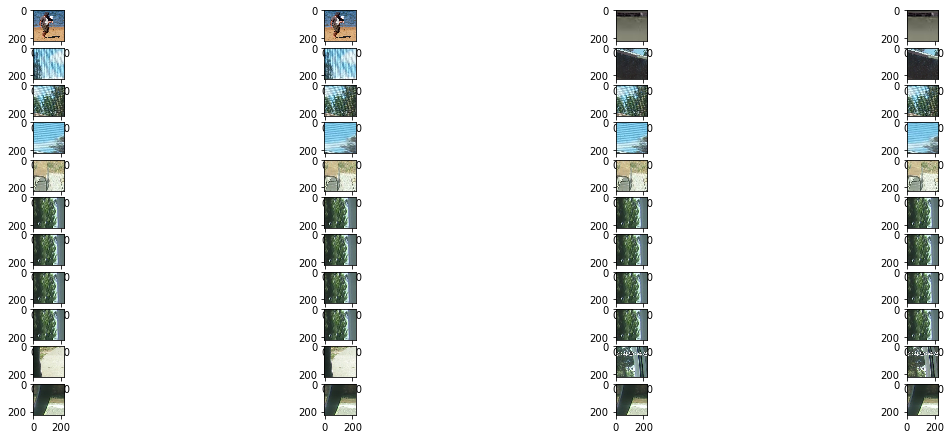

In [30]:
fig = plt.figure(figsize = (20, 15))

for idx, images in enumerate(common_hashes[['name_train','name_test']].values):
    y = fig.add_subplot(len(common_hashes), 4, idx*2+1)
    img = cv2.imread(os.path.join(CURRENT_DIR,images[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    y.imshow(img)

    y = fig.add_subplot(len(common_hashes), 4, idx*2+2)
    img = cv2.imread(os.path.join(CURRENT_DIR,images[1]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    y.imshow(img)

    
plt.show()

In [31]:
# train duplicates - to remove:
train_to_remove = train_dups[train_dups['Hash'] == t.index[0]].drop_duplicates('Hash')[['name']]
train_to_remove.to_csv("train_remove.csv",index=False)
train_to_remove.head()

name
1950  Data/train/noise/144373.JPEG

In [32]:
print(train_to_remove)

                              name
1950  Data/train/noise/144373.JPEG
